In [218]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [205]:
df = pd.read_parquet("geo_parqet_file/atl03x_1_2025-05-07_13_06_41_393.parquet")

# Подивись перші рядки
print(df.head())


                               region  gt  spacecraft_velocity  \
time_ns                                                          
2021-11-26 19:39:20.790408704       6  10          7108.730469   
2021-11-26 19:39:20.795308544       6  10          7108.730469   
2021-11-26 19:39:20.796308480       6  10          7108.730469   
2021-11-26 19:39:20.808008448       6  10          7108.730957   
2021-11-26 19:39:20.808708352       6  10          7108.730957   

                               solar_elevation  longitude  rgt  ph_index  \
time_ns                                                                    
2021-11-26 19:39:20.790408704       -49.910126  24.901195  998     22408   
2021-11-26 19:39:20.795308544       -49.910126  24.901148  998     22419   
2021-11-26 19:39:20.796308480       -49.910126  24.901139  998     22422   
2021-11-26 19:39:20.808008448       -49.910442  24.901029  998     22452   
2021-11-26 19:39:20.808708352       -49.910522  24.901023  998     22454   

    

In [206]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.sample import sample_gen
import numpy as np

# 1. Створення GeoDataFrame
df = pd.read_parquet("geo_parqet_file/atl03x_1_2025-05-07_13_06_41_393.parquet")
gdf = gpd.GeoDataFrame(df, geometry=[Point(xy) for xy in zip(df["longitude"], df["latitude"])], crs="EPSG:4326")

# 2. Завантаження геоїдної моделі (EGG2015)
geoid_path = "/mnt/c/Users/5302/PycharmProjects/geoid/data/raw_data/egg_2015.tif"
coords = [(geom.x, geom.y) for geom in gdf.geometry]

with rasterio.open(geoid_path) as geoid_src:
    geoid_values = list(sample_gen(geoid_src, coords))

# 3. Додавання висоти геоїда та ортометричної висоти
gdf["geoid_height"] = [val[0] if val else np.nan for val in geoid_values]
gdf["orthometric_height"] = gdf["height"] - gdf["geoid_height"]

# 4. Зберегти результат
gdf.to_parquet("icesat2_region_orthometric.parquet", index=False)

In [3]:
print(df.columns)


Index(['region', 'gt', 'spacecraft_velocity', 'solar_elevation', 'longitude',
       'rgt', 'ph_index', 'height', 'atl08_class', 'spot', 'x_atc', 'y_atc',
       'cycle', 'atl03_cnf', 'latitude', 'background_rate', 'quality_ph'],
      dtype='object')


In [3]:
df_filtered = df[
    (df["rgt"] == 998) &
    (df["cycle"] == 1) &
    (df["spot"] == 1) &
    (df["y_atc"] >= -2641.596) &
    (df["y_atc"] <= -2541.596) &
    df["height"].notna() &
    (df["atl03_cnf"] == 4) &
    df["y_atc"].notna() &
    df["cycle"].notna() &

    df["atl08_class"] == 1
]

print(df_filtered.shape)


(36118, 17)


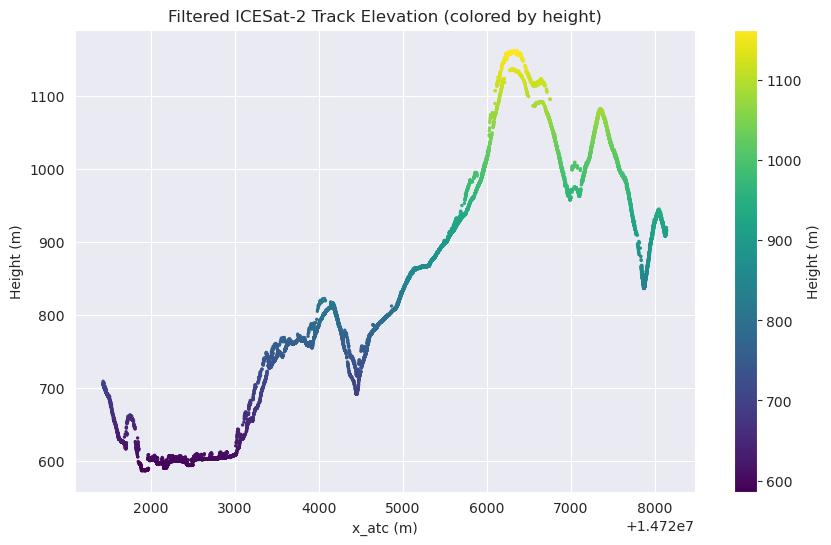

In [4]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(df_filtered["x_atc"], df_filtered["height"], c=df_filtered["height"], cmap="viridis", s=2)
plt.xlabel("x_atc (m)")
plt.ylabel("Height (m)")
plt.colorbar(sc, label="Height (m)")
plt.title("Filtered ICESat-2 Track Elevation (colored by height)")
plt.grid(True)
plt.show()


In [22]:
import pandas as pd
import numpy as np


def clean_ground_bottom(df, window=15, tolerance=0.5, degree=3, residual_tol=1.0):
    """
    Очистка ICESat-2 грунтових даних шляхом визначення нижньої оболонки.

    Параметри:
    - df: pandas DataFrame з колонками 'x_atc', 'height'
    - window: розмір вікна для rolling min
    - tolerance: допустиме відхилення від rolling min
    - degree: порядок полінома для MNK
    - residual_tol: допустиме відхилення від MNK-профілю

    Повертає:
    - df_clean: очищений DataFrame
    """
    df_sorted = df.sort_values("x_atc").copy()

    # Rolling min з вікном
    df_sorted["rolling_min"] = df_sorted["height"].rolling(window=window, center=True).min()

    # Вибираємо точки близькі до "дна"
    df_near_min = df_sorted[
        (df_sorted["height"] - df_sorted["rolling_min"]).abs() < tolerance
    ].copy()

    # MNK: Поліноміальна регресія по x_atc → height
    X = df_near_min["x_atc"].values.reshape(-1, 1)
    y = df_near_min["height"].values
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly, y)
    y_pred = model.predict(X_poly)

    # Вираховуємо відхилення від профілю
    residuals = y - y_pred
    df_near_min["residual"] = residuals

    # Залишаємо лише ті точки, що під профілем або дуже близько
    df_clean = df_near_min[df_near_min["residual"] < residual_tol]

    return df_clean


In [23]:
df_ground_cleaned_rolling_min = clean_ground_bottom(df_filtered)


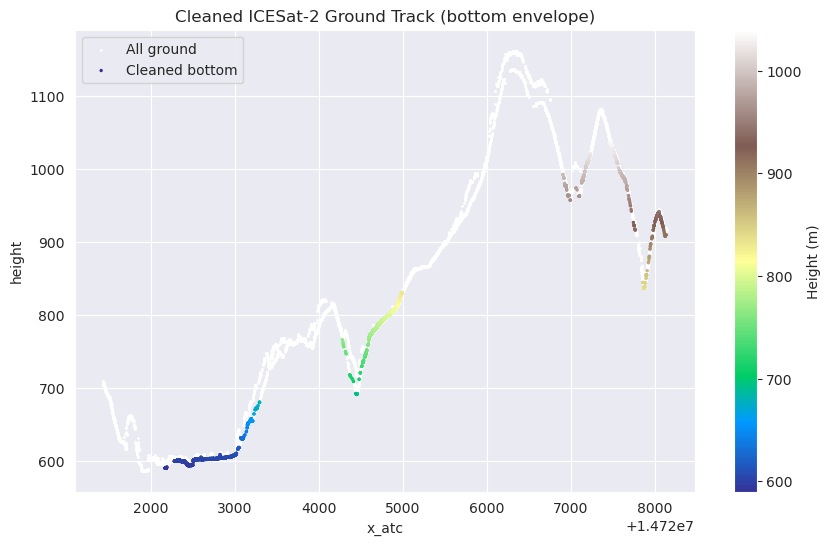

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_filtered["x_atc"], df_filtered["height"], s=1, color="white", label="All ground")
plt.scatter(df_ground_cleaned_rolling_min["x_atc"], df_ground_cleaned_rolling_min["height"], s=2, c=df_ground_cleaned_rolling_min["height"], cmap="terrain", label="Cleaned bottom")
plt.xlabel("x_atc")
plt.ylabel("height")
plt.title("Cleaned ICESat-2 Ground Track (bottom envelope)")
plt.colorbar(label="Height (m)")
plt.legend()
plt.grid(True)
plt.show()



In [39]:
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd

def clean_ground_dbscan(df, eps=10, min_samples=5):
    """
    Кластеризація LiDAR-профілю методом DBSCAN та збереження мінімальної висоти у кожному кластері.

    Параметри:
    - df: DataFrame з колонками x_atc, height
    - eps: радіус для DBSCAN (в метрах)
    - min_samples: мінімальна кількість точок у кластері

    Повертає:
    - df_bottom: тільки найнижчі точки з кожного кластеру
    """
    X = df[["x_atc", "height"]].values

    # DBSCAN кластеризація
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(X)
    df = df.copy()
    df["cluster"] = clustering.labels_

    # Видалити шуми (label = -1)
    df = df[df["cluster"] != -1]

    # Залишаємо лише найнижчі точки в кожному кластері
    df_bottom = df.loc[df.groupby("cluster")["height"].idxmin()]

    return df_bottom


In [212]:
df_ground_cleaned_dbscan = clean_ground_dbscan(df_filtered, eps=1.1, min_samples=5)


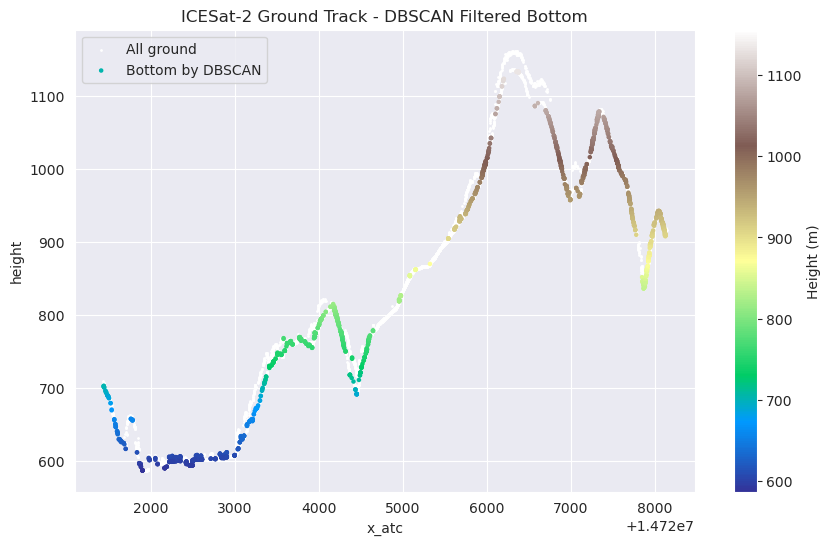

In [213]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(df_filtered["x_atc"], df_filtered["height"], s=1, color="white", label="All ground")
plt.scatter(df_ground_cleaned_dbscan["x_atc"], df_ground_cleaned_dbscan["height"], s=5, c=df_ground_cleaned_dbscan["height"], cmap="terrain", label="Bottom by DBSCAN")
plt.xlabel("x_atc")
plt.ylabel("height")
plt.title("ICESat-2 Ground Track - DBSCAN Filtered Bottom")
plt.colorbar(label="Height (m)")
plt.legend()
plt.grid(True)
plt.show()


In [25]:
def clean_ground_flexible(df, window=15, tolerance=0.8, group_width=10):
    """
    Залишає всі точки у межах певного діапазону від rolling min, зберігаючи “дно” не як одну точку, а як групу.

    - window: ширина rolling-вікна
    - tolerance: висотне відхилення від локального мінімуму
    - group_width: розмір блоку в метрах
    """
    df = df.sort_values("x_atc").copy()
    df["rolling_min"] = df["height"].rolling(window=window, center=True).min()

    # Залишаємо точки в межах допуску від rolling min
    df["is_near_bottom"] = (df["height"] - df["rolling_min"]).abs() < tolerance

    # Групування по x_atc — розбивка на блоки по group_width
    df["block"] = (df["x_atc"] / group_width).astype(int)

    # Зберігаємо лише блоки, де є достатньо “днищевих” точок
    kept_blocks = df[df["is_near_bottom"]].groupby("block").filter(lambda g: len(g) >= 2)["block"].unique()

    df_clean = df[df["block"].isin(kept_blocks) & df["is_near_bottom"]]

    return df_clean


In [26]:
df_ground_flexible = clean_ground_flexible(df_filtered, window=15, tolerance=0.8, group_width=30)

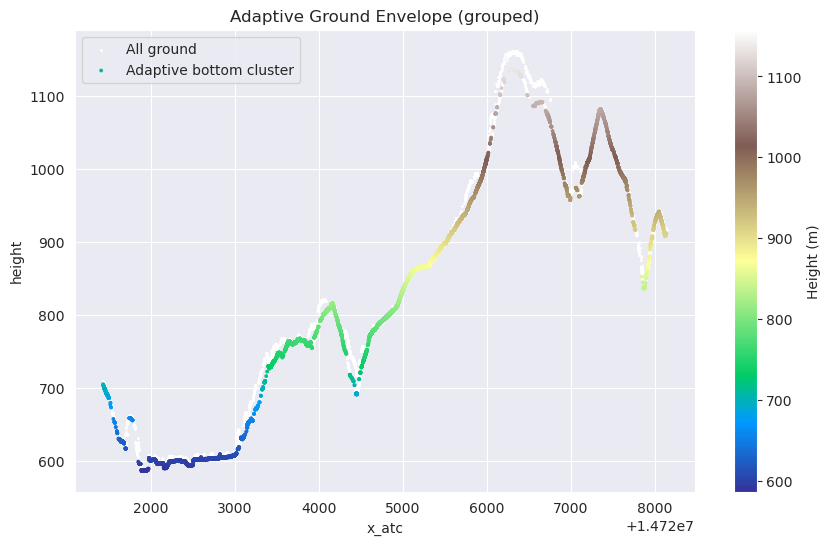

In [27]:


plt.figure(figsize=(10, 6))
plt.scatter(df_filtered["x_atc"], df_filtered["height"], s=1, color="white", label="All ground")
plt.scatter(df_ground_flexible["x_atc"], df_ground_flexible["height"], s=3, c=df_ground_flexible["height"], cmap="terrain", label="Adaptive bottom cluster")
plt.xlabel("x_atc")
plt.ylabel("height")
plt.title("Adaptive Ground Envelope (grouped)")
plt.colorbar(label="Height (m)")
plt.legend()
plt.grid(True)
plt.show()


In [28]:
print("Початково:", df_filtered.shape)
print("Після очищення:", df_ground_flexible.shape)


Початково: (36118, 17)
Після очищення: (25511, 20)


In [30]:
def clean_ground_mnk_local(df, window_size=150, step=50, degree=2, residual_tol=0.2):
    """
    Локальне очищення ґрунтових точок за допомогою рухомої MNK-регресії.

    - window_size: ширина вікна по x_atc (у метрах)
    - step: крок між вікнами
    - degree: поліноміальний порядок регресії
    - residual_tol: максимальна відстань над моделлю, щоб точку залишити

    Повертає: DataFrame з відфільтрованими точками
    """
    df = df.sort_values("x_atc").copy()
    x = df["x_atc"].values
    result = []

    start = x.min()
    end = x.max()

    for x0 in np.arange(start, end, step):
        x_start = x0
        x_end = x0 + window_size
        df_window = df[(df["x_atc"] >= x_start) & (df["x_atc"] <= x_end)]

        if len(df_window) < degree + 1:
            continue

        # МНК-регресія на локальному вікні
        X = df_window["x_atc"].values.reshape(-1, 1)
        y = df_window["height"].values
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X)

        model = LinearRegression().fit(X_poly, y)
        y_pred = model.predict(X_poly)
        residuals = y - y_pred

        # Зберігаємо точки, що не перевищують профіль
        df_valid = df_window[residuals <= residual_tol]
        result.append(df_valid)

    if result:
        return pd.concat(result)
    else:
        return pd.DataFrame(columns=df.columns)


In [31]:
df_ground_mnk_local = clean_ground_mnk_local(
    df_filtered, window_size=50, step=15, degree=2, residual_tol=0.7
)


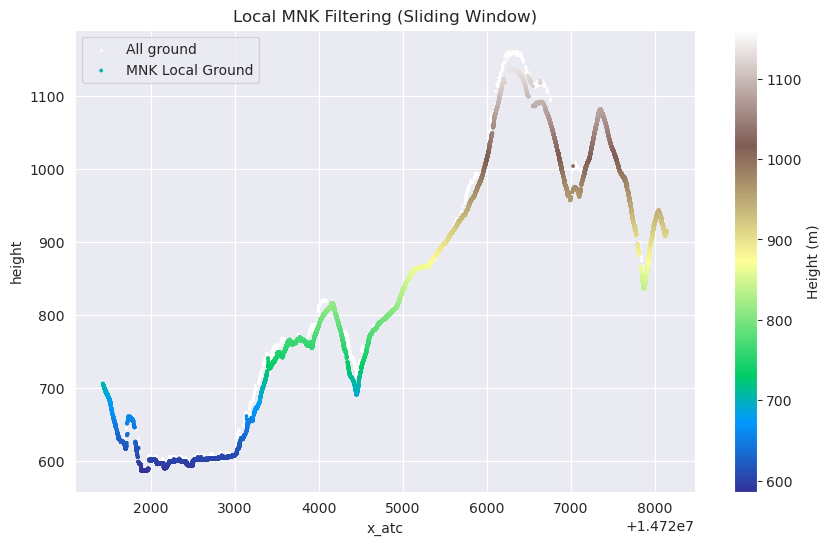

In [32]:
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered["x_atc"], df_filtered["height"], s=1, color="white", label="All ground")
plt.scatter(df_ground_mnk_local["x_atc"], df_ground_mnk_local["height"], s=3, c=df_ground_mnk_local["height"], cmap="terrain", label="MNK Local Ground")
plt.xlabel("x_atc")
plt.ylabel("height")
plt.title("Local MNK Filtering (Sliding Window)")
plt.colorbar(label="Height (m)")
plt.legend()
plt.grid(True)
plt.show()



In [311]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def clean_ground_loess(df, frac=0.02, residual_tol=0.2):
    df = df.sort_values("x_atc").copy()
    smoothed = lowess(df["height"], df["x_atc"], frac=frac, return_sorted=False)
    residuals = df["height"] - smoothed
    df_clean = df[residuals <= residual_tol]
    return df_clean, smoothed


In [312]:
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

def clean_ground_quantile(df, degree=2, quantile=0.1, residual_tol=0.2):
    df = df.sort_values("x_atc").copy()
    X = df["x_atc"].values.reshape(-1, 1)
    y = df["height"].values

    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)

    mod = QuantReg(y, X_poly)
    res = mod.fit(q=quantile)
    y_pred = res.predict(X_poly)

    residuals = y - y_pred
    df_clean = df[residuals <= residual_tol]
    return df_clean, y_pred



In [314]:
df_ground_quantile, y_quantile = clean_ground_quantile(
    df_filtered, degree=2, quantile=0.1, residual_tol=0.2
)


In [334]:
df_ground_loess, smoothed_loess = clean_ground_loess(
    df_filtered, frac=0.02, residual_tol=0.8
)


In [6]:
def hybrid_mnk_rolling(df, window=15, degree=3, tol_mnk=0.3, tol_roll=0.2):
    df = df.sort_values("x_atc").copy()

    # MNK-профіль
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures

    X = df["x_atc"].values.reshape(-1, 1)
    y = df["height"].values
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression().fit(X_poly, y)
    y_pred = model.predict(X_poly)

    df["residual_mnk"] = y - y_pred
    df["rolling_min"] = df["height"].rolling(window=window, center=True).min()
    df["deviation_roll"] = (df["height"] - df["rolling_min"]).abs()

    # Умова: ближче до моделі і до локального дна
    df_clean = df[
        (df["residual_mnk"] <= tol_mnk) &
        (df["deviation_roll"] <= tol_roll)
    ]

    return df_clean, y_pred


In [42]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

def clean_ground_mnk_local_enhanced(df, window_size=150, step=50, degree=2, lower_tol=-0.5, upper_tol=1.0, shift_down=0.3):
    """
    Покращене локальне очищення ґрунтових точок за допомогою рухомої MNK-регресії.
    Замість суворої обрізки, використовує верхню/нижню межу + зміщення вниз.

    - window_size: ширина вікна по x_atc (у метрах)
    - step: крок між вікнами
    - degree: поліноміальний порядок регресії
    - lower_tol: нижня межа залишення точки (відносно моделі)
    - upper_tol: верхня межа залишення точки (відносно моделі)
    - shift_down: вертикальне зміщення моделі вниз для нижнього контуру

    Повертає: DataFrame з відфільтрованими точками
    """
    df = df.sort_values("x_atc").copy()
    x = df["x_atc"].values
    result = []

    start = x.min()
    end = x.max()

    for x0 in np.arange(start, end, step):
        x_start = x0
        x_end = x0 + window_size
        df_window = df[(df["x_atc"] >= x_start) & (df["x_atc"] <= x_end)]

        if len(df_window) < degree + 1:
            continue

        X = df_window["x_atc"].values.reshape(-1, 1)
        y = df_window["height"].values
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X)

        model = LinearRegression().fit(X_poly, y)
        y_pred = model.predict(X_poly) - shift_down  # зсув моделі вниз
        residuals = y - y_pred

        mask = (residuals >= lower_tol) & (residuals <= upper_tol)
        df_valid = df_window[mask]
        result.append(df_valid)

    if result:
        return pd.concat(result)
    else:
        return pd.DataFrame(columns=df.columns)



In [55]:
df_ground_mnk_local1 = clean_ground_mnk_local_enhanced(df_filtered, window_size=90, step=25, degree=2, lower_tol=-1.0, upper_tol=1.0, shift_down=0.5)

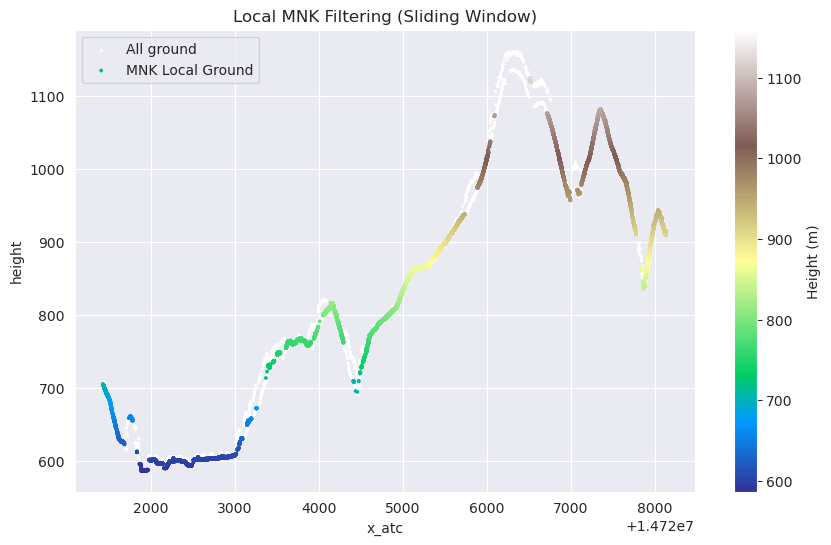

In [56]:
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered["x_atc"], df_filtered["height"], s=1, color="white", label="All ground")
plt.scatter(df_ground_mnk_local1["x_atc"], df_ground_mnk_local1["height"], s=3, c=df_ground_mnk_local1["height"], cmap="terrain", label="MNK Local Ground")
plt.xlabel("x_atc")
plt.ylabel("height")
plt.title("Local MNK Filtering (Sliding Window)")
plt.colorbar(label="Height (m)")
plt.legend()
plt.grid(True)
plt.show()


In [183]:
df_filtered = df[
    (df["rgt"] == 998) &
    (df["cycle"] == 1) &
    (df["spot"] == 1) &
    (df["y_atc"] >= -2641.596) &
    (df["y_atc"] <= -2541.596) &
    df["height"].notna() &
    (df["atl03_cnf"] == 4)

]

In [177]:
df_filtered_ground = df[
    (df["rgt"] == 998) &
    (df["cycle"] == 1) &
    (df["spot"] == 1) &
    (df["y_atc"] >= -2641.596) &
    (df["y_atc"] <= -2541.596) &
    df["height"].notna() &
    (df["atl03_cnf"] == 4) &
    # df["y_atc"].notna() &
    # df["cycle"].notna() &

    df["atl08_class"] == 1
]

print(df_filtered.shape)

(36118, 17)


In [169]:
print(df_filtered_canopy.head(300))

                               region  gt  spacecraft_velocity  \
time_ns                                                          
2018-12-02 23:41:20.946634240       6  60          7108.312012   
2018-12-02 23:41:20.946634240       6  60          7108.312012   
2018-12-02 23:41:20.946634240       6  60          7108.312012   
2018-12-02 23:41:20.946634240       6  60          7108.312012   
2018-12-02 23:41:20.946634240       6  60          7108.312012   
...                               ...  ..                  ...   
2018-12-02 23:41:20.955134464       6  60          7108.312500   
2018-12-02 23:41:20.955234304       6  60          7108.312500   
2018-12-02 23:41:20.955334400       6  60          7108.312500   
2018-12-02 23:41:20.955334400       6  60          7108.312500   
2018-12-02 23:41:20.955334400       6  60          7108.312500   

                               solar_elevation  longitude  rgt  ph_index  \
time_ns                                                          

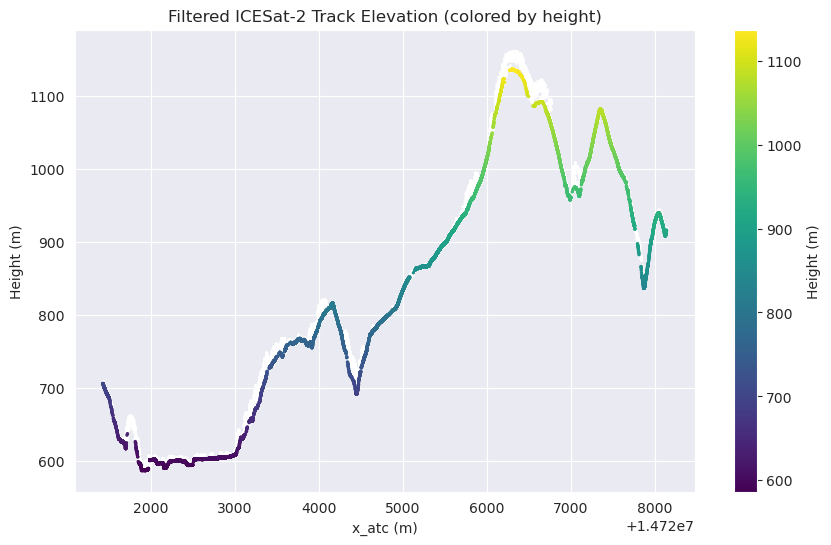

In [184]:
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered["x_atc"], df_filtered["height"], s=1, color="white", label="All ground")

plt.scatter(df_filtered_canopy["x_atc"], df_filtered_canopy["height"], c=df_filtered_canopy["height"], cmap="viridis", s=2)

plt.xlabel("x_atc (m)")
plt.ylabel("Height (m)")
plt.colorbar(label="Height (m)")
plt.title("Filtered ICESat-2 Track Elevation (colored by height)")
plt.grid(True)
plt.show()

In [185]:
print(df["atl08_class"].unique())


[2 1 3]


In [111]:
print(df["atl08_class"].value_counts(dropna=False))


atl08_class
2    269966
1    185920
3     82547
Name: count, dtype: int64


In [115]:
print(df["atl08_class"].describe())


count    538433.000000
mean          1.808011
std           0.679521
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           3.000000
Name: atl08_class, dtype: float64


In [116]:
df_canopy = df[df["atl08_class"] == 2]


In [117]:
print(df[df["atl08_class"] == 2]["spot"].value_counts())


spot
5    81809
1    68647
3    63183
6    20140
4    19928
2    16259
Name: count, dtype: int64


In [213]:
df_canopy = df[
    (df["rgt"] == 998) &
    (df["cycle"] == 1) &
    (df["spot"] == 1) &

    (df["atl03_cnf"] == 4) &
    (df["atl08_class"] == 3)
]


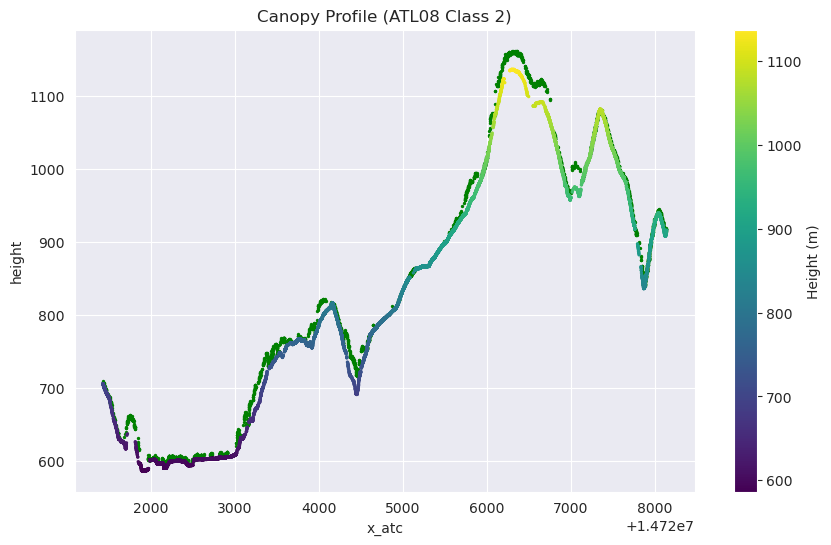

In [208]:
plt.figure(figsize=(10, 6))
plt.scatter(df_canopy["x_atc"], df_canopy["height"], s=2, color="g")
plt.scatter(df_filtered_canopy["x_atc"], df_filtered_canopy["height"], c=df_filtered_canopy["height"], cmap="viridis", s=2)

plt.xlabel("x_atc")
plt.ylabel("height")
plt.title("Canopy Profile (ATL08 Class 2)")
plt.colorbar(label="Height (m)")
plt.grid(True)
plt.show()


In [219]:
df_ortometric = gpd.read_parquet("icesat2_region_orthometric.parquet")



In [220]:
df_canopy_orto = df_ortometric[
    (df_ortometric["rgt"] == 998) &
    (df_ortometric["cycle"] == 1) &
    (df_ortometric["spot"] == 1) &

    (df_ortometric["atl03_cnf"] == 4) &
    (df_ortometric["atl08_class"] == 3)
]

In [221]:
df_ground_orto = df_ortometric[
    (df_ortometric["rgt"] == 998) &
    (df_ortometric["cycle"] == 1) &
    (df_ortometric["spot"] == 1) &

    (df_ortometric["atl03_cnf"] == 4) &
    (df_ortometric["atl08_class"] == 1)
]

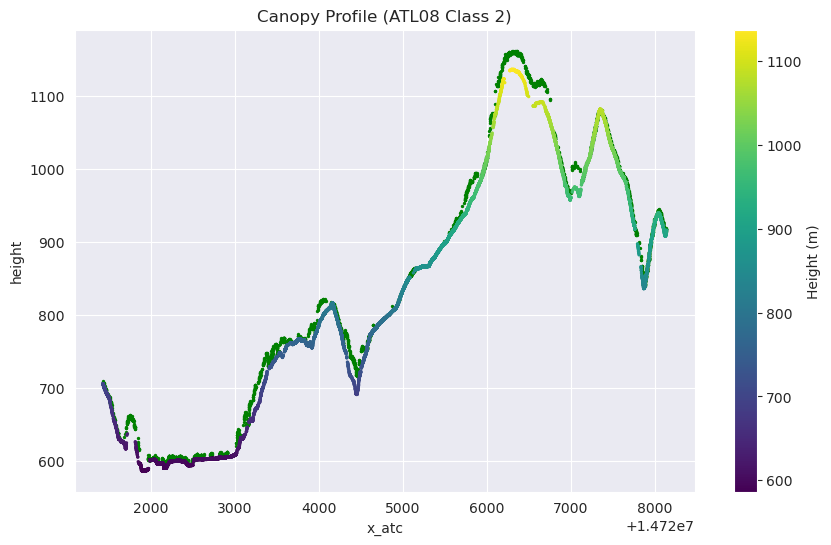

In [222]:
plt.figure(figsize=(10, 6))
plt.scatter(df_canopy_orto["x_atc"], df_canopy_orto["height"], s=2, color="g")
plt.scatter(df_ground_orto["x_atc"], df_ground_orto["height"], c=df_filtered_canopy["height"], cmap="viridis", s=2)

plt.xlabel("x_atc")
plt.ylabel("height")
plt.title("Canopy Profile (ATL08 Class 2)")
plt.colorbar(label="Height (m)")
plt.grid(True)
plt.show()


In [223]:
print(df_ortometric)

        region  gt  spacecraft_velocity  solar_elevation  longitude  rgt  \
0            6  10          7108.730469       -49.910126  24.901195  998   
1            6  10          7108.730469       -49.910126  24.901148  998   
2            6  10          7108.730469       -49.910126  24.901139  998   
3            6  10          7108.730957       -49.910442  24.901029  998   
4            6  10          7108.730957       -49.910522  24.901023  998   
...        ...  ..                  ...              ...        ...  ...   
538428       2  50          7101.936523       -49.864948  24.923290  396   
538429       2  50          7101.936523       -49.864948  24.923290  396   
538430       2  50          7101.936523       -49.864948  24.923288  396   
538431       2  50          7101.936523       -49.864948  24.923286  396   
538432       2  50          7101.936523       -49.864948  24.923284  396   

        ph_index      height  atl08_class  spot         x_atc        y_atc  \
0        

In [224]:
coords = [(geom.x, geom.y) for geom in df_ortometric.geometry]


In [225]:
print("ICESat CRS:", df_ortometric.crs)


ICESat CRS: {"$schema": "https://proj.org/schemas/v0.7/projjson.schema.json", "type": "GeographicCRS", "name": "WGS 84", "datum_ensemble": {"name": "World Geodetic System 1984 ensemble", "members": [{"name": "World Geodetic System 1984 (Transit)"}, {"name": "World Geodetic System 1984 (G730)"}, {"name": "World Geodetic System 1984 (G873)"}, {"name": "World Geodetic System 1984 (G1150)"}, {"name": "World Geodetic System 1984 (G1674)"}, {"name": "World Geodetic System 1984 (G1762)"}, {"name": "World Geodetic System 1984 (G2139)"}, {"name": "World Geodetic System 1984 (G2296)"}], "ellipsoid": {"name": "WGS 84", "semi_major_axis": 6378137, "inverse_flattening": 298.257223563}, "accuracy": "2.0", "id": {"authority": "EPSG", "code": 6326}}, "coordinate_system": {"subtype": "ellipsoidal", "axis": [{"name": "Geodetic latitude", "abbreviation": "Lat", "direction": "north", "unit": "degree"}, {"name": "Geodetic longitude", "abbreviation": "Lon", "direction": "east", "unit": "degree"}]}, "scope":

In [226]:
dem_name_map = {
    "tan_dem": "TanDEM-X",
    "srtm_dem": "SRTM",
    "fab_dem": "FABDEM",
    "copernicus_dem": "Copernicus DEM",
    "nasa_dem": "NASADEM",
    "alos_dem": "ALOS",
    "aster_dem": "ASTER"}